## Pix2Pix: Image-to-image translation with a conditional GAN. 
***

#### _This notebook demonstrates image to image translation using conditional GANs. Using this technique, we can colorize grayscale photos, convert google maps to google earth, etc._

#### _It demonstrates how to convert building facades to real buildings. It does so by conditioning on input images and generating corresponding output images._

In this example, we will use the `CMP Facade Database`

In [ ]:
import os
import time
import pathlib
import datetime
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
dataset_name = 'facades'
URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(fname = f'{dataset_name}.tar.gz',
                                     origin = URL,
                                     extract = True)

path_to_zip = pathlib.Path(path_to_zip)
PATH = path_to_zip.parent/dataset_name

30179328/30168306 [==============================] - 17s 1us/step


In [ ]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/facades.tar.gz'),
 PosixPath('/root/.keras/datasets/facades')]

In [ ]:
#Each original image is of size 256 * 512 containing 256 * 256 images.
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
sample_image.shape

TensorShape([256, 512, 3])

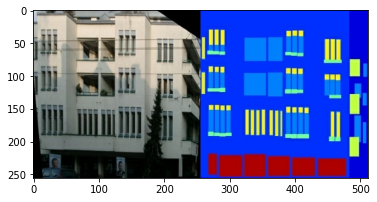

In [ ]:
plt.figure()
plt.imshow(sample_image)

In [ ]:
#Define a function that loads image files and outputs two image tensors.
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    #Split each image tensor into 2 tensors: 
    #1. One with a real building facade image.
    #2. One with an architectural label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]
    
    #Convert both images to float32 tensors.
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
   
    return input_image, real_image

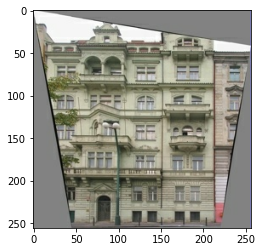

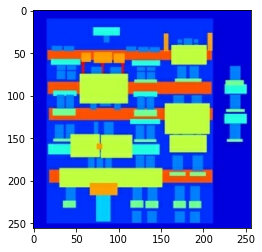

In [ ]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(re / 255.0)
plt.figure()
plt.imshow(inp / 255.0)

### You need to apply random jittering and mirroring to preprocess the train set.
#### Define several functions that:
- Resize each `256 * 256` image to a larger height and width --> '286 * 286'
- Randomly crop it back to `256 * 256`.
- Randomly flip the image horizontally.
- Normalize the images to `[-1, 1]` range.

In [ ]:
#The facade training set consists of 400 images.
BUFFER_SIZE = 400

#The batch size of 1 produced better results for the U-Net in the original pix2pix experiment.
BATCH_SIZE = 1

#Each image is 256 * 256 in size.
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis = 0)
    cropped_image = tf.image.random_crop(
        stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

In [ ]:
#Normalize the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
    #Resize image to 286 * 286
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    #Random cropping back to 256 * 256
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
        #Random mirroring.
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

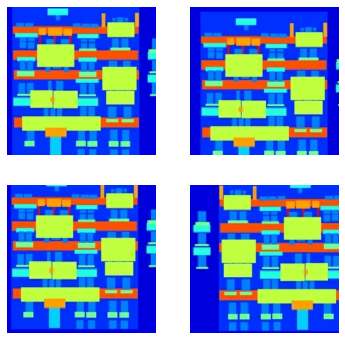

In [ ]:
#Inspect some of the preprocessed output.
plt.figure(figsize = (6, 6))

for item in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, item + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [ ]:
#Define helper functions that load and preprocess the train and test sets.
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [ ]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, 
                                    IMG_HEIGHT, IMG_WIDTH)
    
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [ ]:
#Build an input pipeline with tf.data
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = (train_dataset.map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                )

train_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))

In [ ]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

test_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))

### Build the generator.
- The generator of your pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder (downsampler) and a decoder. (upsampler)
- Each block in the encodet is: Convolution --> Batch normalization --> Leaky ReLU
- Each block in the decoder is: Transposed convolution --> Batch normalization --> Dropout (applied to the first 3 blocks) --> ReLU

In [ ]:
#Define the downsampler.
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                              kernel_initializer = initializer, use_bias = False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [ ]:
#Define the upsampler. (decoder)
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0, 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides = 2,
                                       padding = 'same', 
                                       kernel_initializer = initializer,
                                       use_bias = False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [ ]:
#Define the generator with the downsampler and the upsampler.
def Generator():
    inputs = tf.keras.layers.Input(shape = [256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), #(batch_size, 128, 128, 64)
        downsample(128, 4), #(batch_size, 64, 64, 128)
        downsample(256, 4), #(batch_size, 32, 32, 256)
        downsample(512, 4), #(batch_size, 16, 16, 512)
        downsample(512, 4), #(batch_size, 8, 8, 512)
        downsample(512, 4), #(batch_size, 4, 4, 512)
        downsample(512, 4), #(batch_size, 2, 2, 1)
        downsample(512, 4), #(batch_size, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout = True), #(batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout = True), #(batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout = True), #(batch_size, 8, 8, 1024)
        upsample(512, 4), #(batch_size, 16, 16, 1024)
        upsample(256, 4), #(batch_size, 32, 32, 512)
        upsample(128, 4), #(batch_size, 64, 64, 256)
        upsample(64, 4), #(batch_size, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, 
                                          strides = 2, padding = 'same',
                                          kernel_initializer=initializer,
                                          activation = 'tanh') #(batch_size, 256, 256, 3)
    x = inputs
    
    #Downsampling through the model.
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    #Upsampling and establishing the skip connections.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    return tf.keras.Model(inputs = inputs, outputs = x)

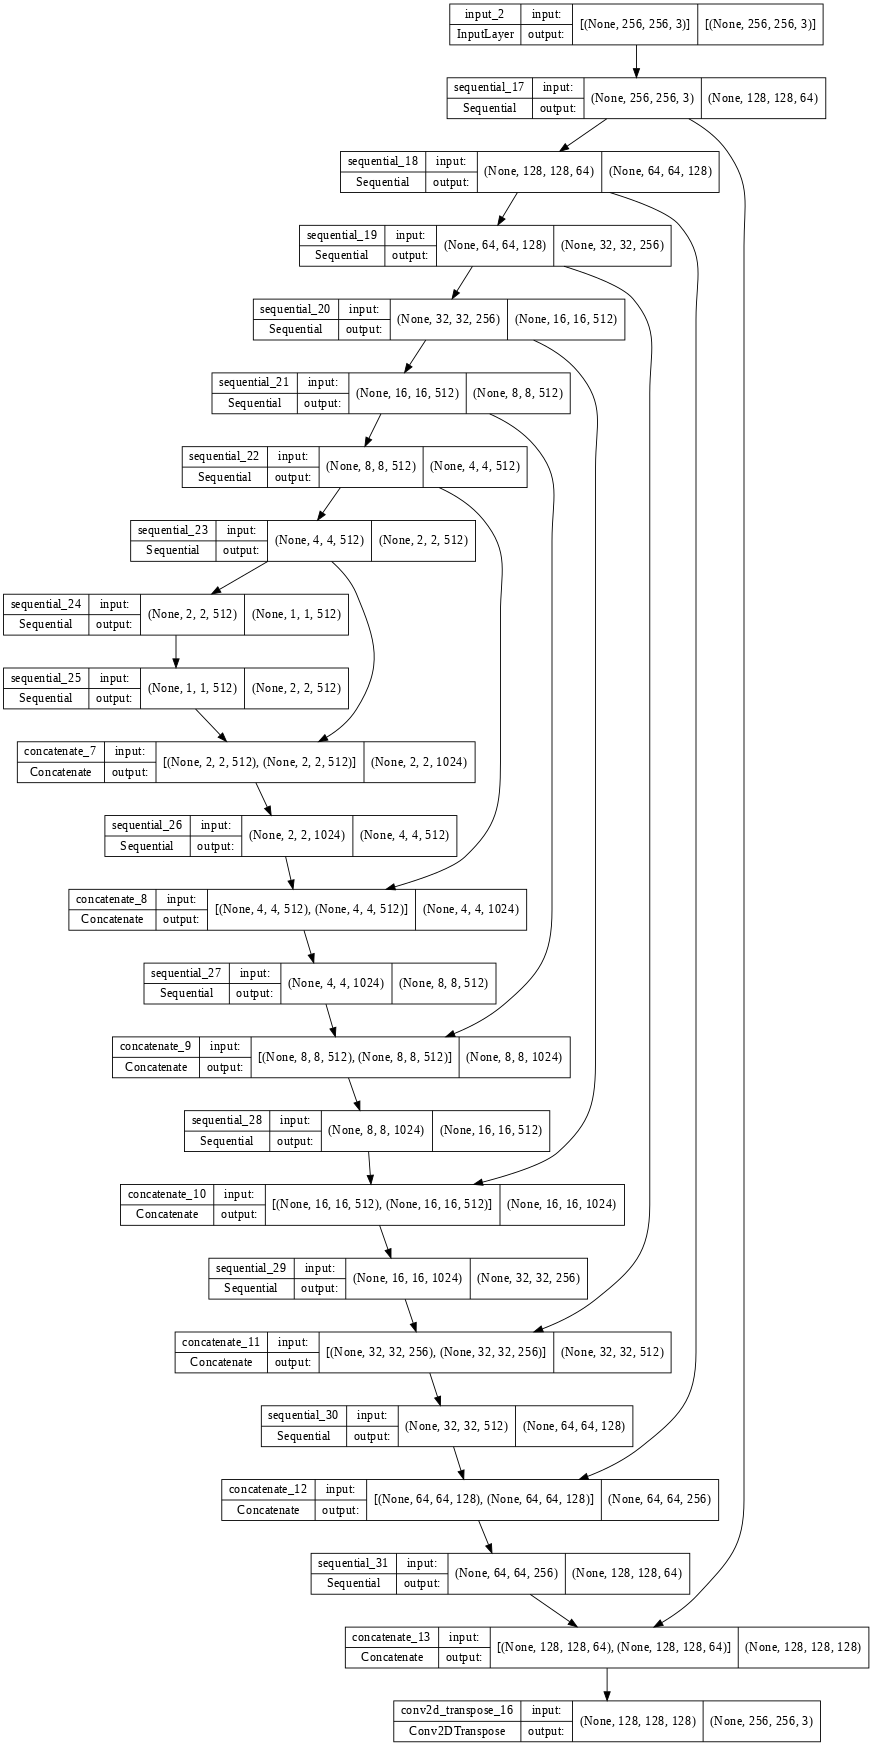

In [ ]:
#Visualize the generator model architecture.
from keras.utils.vis_utils import plot_model

generator = Generator()
plot_model(generator, show_shapes = True, dpi = 64)

In [ ]:
#Test the generator.
gen_output = generator(inp[tf.newaxis, ...], training = False)
gen_output.shape

TensorShape([1, 256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


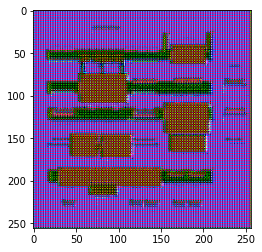

In [ ]:
plt.imshow(gen_output[0, ...])

### Define the generator loss.

GANs learn a loss that adapts to the data, while cGANs lear a structured loss that penalizes a possible structure that differs from the network output and the target image.

- The generator loss is a `sigmoid cross-entropy` loss of the generated images and an *array of ones.* 
- The `pix2pix` paper also mentions the L1 loss, which is a `MAE (mean absolute error)` between the generated image and the target image.
- This allows the generated image to become structurally simiar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA *l1_loss`, where `LAMBDA = 100` 

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    #Mean absolute error.
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

### Build the discriminator.
#### The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier-it tries to classify if each image patch is real or not real.

- Each block in the diecriminator is; Convolution --> Batchnormalization -->LeakyReLU
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
- The input image and the target image, which should classify as real.
- The input image and the generated image (output of the generator), which it should classify as fake.
- The `tf.concat([inp, tar], axis = -1)` to concatenate these 2 inputs together.

In [ ]:
#Define the discriminator.
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape = [256, 256, 3], name = 'input_image')
    tar = tf.keras.layers.Input(shape = [256, 256, 3], name = 'target_image')
    
    x = tf.keras.layers.concatenate([inp, tar]) #(batch_size, 256, 256, channels * 2)
    
    down1 = downsample(64, 4, False)(x) #(batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1) #(batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2) #(batch_size, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) #(batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1, 
                                 kernel_initializer = initializer,
                                 use_bias = False)(zero_pad1) #(batch_size, 31, 31, 512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #(batch_size, 33, 33, 512)
    
    last = tf.keras.layers.Conv2D(1, 4, strides = 1, 
                                 kernel_initializer = initializer)(zero_pad2) #(batch_size, 30, 30, 1)
    return tf.keras.Model(inputs = [inp, tar], outputs = last)

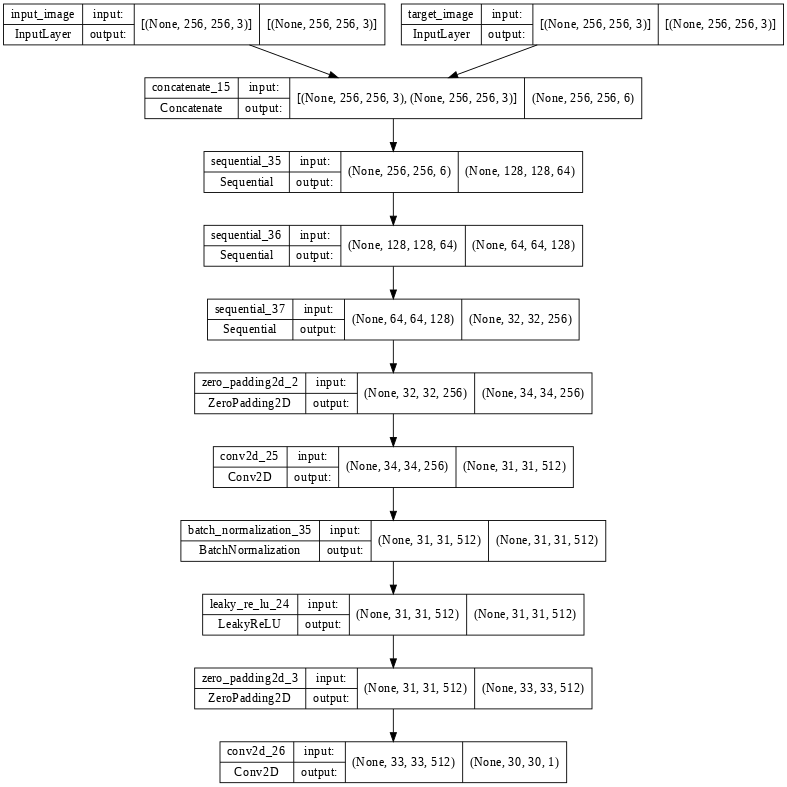

In [ ]:
#Visualize the discriminator model architecture.
discriminator = Discriminator()
plot_model(discriminator, show_shapes = True, dpi = 64)

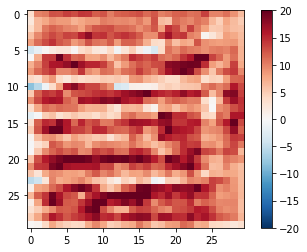

In [ ]:
#Test the discriminator.
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training = False)
plt.imshow(disc_out[0, ..., -1], vmin = -20, vmax = 20, cmap = 'RdBu_r')
plt.colorbar()

### Define the discriminator loss.
- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images.**
- `real_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images).**
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss = generated_loss
    
    return total_disc_loss

In [ ]:
#Define the optimizers and a checkpoint saver.
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/pix2pix/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

#### Generate images.
Write a function to plot some images during training.
- Pass images from the test set to the generator.
- The generator will then translate the input into the output.
- The last step is to plot th predictions, and _voila!_

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training = True)
    plt.figure(figsize = (15, 15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input image', 'Ground truth', 'Predicted image']
    
    for item in range(3):
        plt.subplot(1, 3, item + 1)
        plt.title(title[item])
        #Getting the pixel values in the range [0, 1] to plot.
        plt.imshow(display_list[item] * 0.5 + 0.5)
        plt.axis('off')
        
    plt.show()

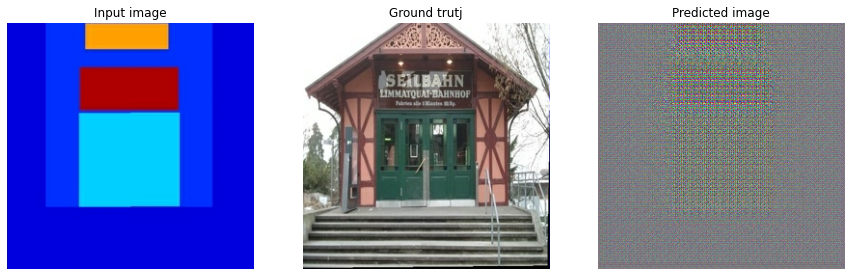

In [ ]:
#Test the function.
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Training.
- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to bothe the generator and the disciminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to `TensorBoard`

In [ ]:
log_dir = '/content/drive/MyDrive/pix2pix/logs/'
summary_writer = tf.summary.create_file_writer(
log_dir + 'fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [ ]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training = True)
        
        disc_real_output = discriminator([input_image, target], training = True)
        disc_generated_output = discriminator([input_image, gen_output], training = True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_total_loss, 
                                           generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                           generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                               discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step = step // 1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step = step // 1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step = step // 1000)
        tf.summary.scalar('disc_loss', disc_loss, step = step // 1000)

#### Since this notebook can run of more than one dataset, and the datasets vary greatly in the size the training loop is setup to work in steps instead of epochs.
- Iterates over the number of steps.
- Every 10 steps print a dot (`.`)
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait = True)
            
            if step != 0:
                print(f'Time taken for 1K steps: {time.time() - start:.2f} sec\n')
                
            start = time.time()
            generate_images(generator, example_input, example_target)
            print(f'Step; {step // 1000}k')
            
        train_step(input_image, target, step)
        
        #Training step.
        if (step + 1) % 10 == 0:
            print('.', end = '', flush = True)
            
        #Save (checkpoint) the model every 5K steps.
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

Time taken for 1K steps: 89.50 sec



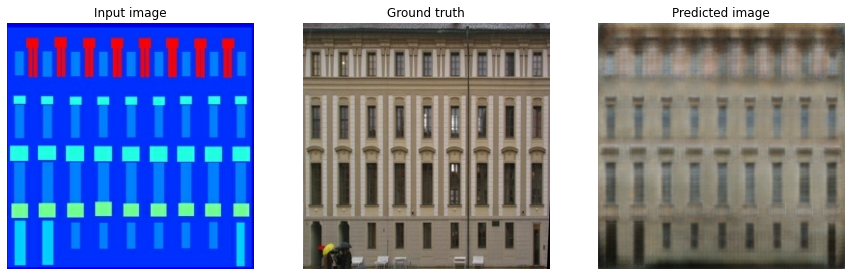

Step; 79k
....................................................................................................

In [ ]:
#Finally!!! Run the train loop.
fit(train_dataset, test_dataset, steps = 80_000)